In [2]:
import pandas as pd
import numpy as np
from scipy.stats import lognorm, norm, t
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from tqdm import tqdm
import seaborn as sns

np.random.seed(777)

# Generating random skewed distributions
We will generate random log normal distributions. These distributions represent the underlying distribution of outcomes associated with a different variants of a product. For example, the distribution could represent the distribution of revenue per user (a known skewed metric) associated with a given product variant.

In [3]:
def generate_random_log_normal(mu_lower=0, mu_upper=0.5, sigma_lower=1, sigma_upper=1.5):
    mu = np.random.uniform(mu_lower, mu_upper)
    sigma = np.random.uniform(sigma_lower, sigma_upper)
    lognorm_dist = lognorm(s = sigma, scale = np.exp(mu))
    return lognorm_dist

Text(0, 0.5, 'Probability density')

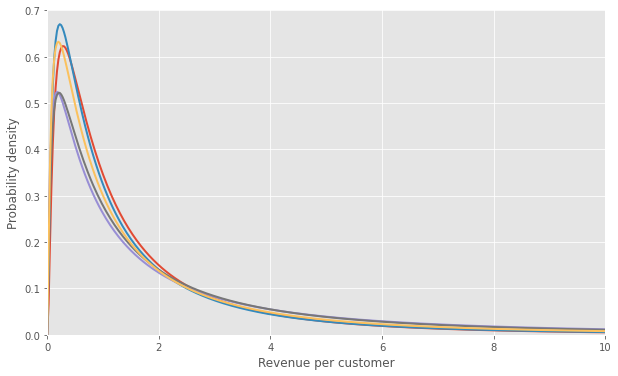

In [4]:
plt.rcParams['figure.figsize'] = 10,6
number_to_plot = 5
x = np.linspace(0, 10, 400)

for _ in range(number_to_plot):
    distribution = generate_random_log_normal()
    plt.plot(x, distribution.pdf(x), linewidth=2)
    
plt.xlim(np.min(x), np.max(x))
plt.ylim(bottom=0)
plt.xlabel('Revenue per customer')
plt.ylabel('Probability density')
# plt.savefig('rpc_distributions')

## Getting a random sample from the distribution

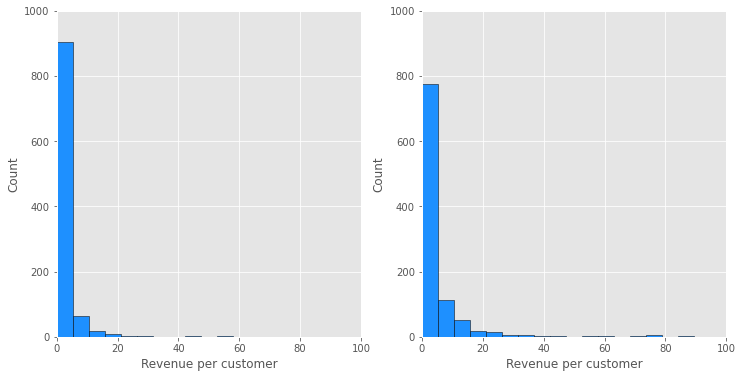

In [5]:
plt.rcParams['figure.figsize'] = 12,6
num_samples = 1000
np.random.seed()

plt.subplot(1,2, 1)
distribution = generate_random_log_normal()
sample = distribution.rvs(num_samples)
plt.hist(sample, bins=np.linspace(0,100, 20), color='dodgerblue', edgecolor='k')
plt.xlim(0,100)
plt.ylim(0,1000)
plt.xlabel('Revenue per customer')
plt.ylabel('Count')

plt.subplot(1,2, 2)
distribution = generate_random_log_normal()
sample = distribution.rvs(num_samples)
plt.hist(sample, bins=np.linspace(0,100, 20), color='dodgerblue', edgecolor='k')
plt.xlim(0,100)
plt.ylim(0,1000)
plt.xlabel('Revenue per customer')
plt.ylabel('Count')
plt.savefig('test_data.png', dpi=300)

In [6]:
def choose_lottery_mean_maxers(sample_data_A, sample_data_B):
    if np.mean(sample_data_A) >= np.mean(sample_data_B):
        return 'distribution_A'
    else:
        return 'distribution_B'
    
def choose_lottery_median_maxers(sample_data_A, sample_data_B):
    if np.median(sample_data_A) >= np.median(sample_data_B):
        return 'distribution_A'
    else:
        return 'distribution_B'

In [7]:
num_simulations = 5000
num_samples = 1000
num_draws_at_scale = 100000


company_policies = {
    'Mean Maxers': choose_lottery_mean_maxers,
    'Median Maxers': choose_lottery_median_maxers,
}

companies = list(company_policies.keys())
simulated_rewards = {company: np.zeros(num_simulations) for company in companies}
selections = {company: [] for company in companies}

for i in tqdm(range(num_simulations)):
    # Generating distributions that the companies must choose between
    distributions = {
        'distribution_A': generate_random_log_normal(),
        'distribution_B': generate_random_log_normal()
    }

    # Generating sample data
    sample_data_A = distributions['distribution_A'].rvs(size=num_samples)
    sample_data_B = distributions['distribution_B'].rvs(size=num_samples)
    
    for company in companies:
        # Each company chooses between distribution A or B based on their policy
        chosen_distribution = company_policies[company](sample_data_A, sample_data_B)
        
        # Then each company incurs a reward from the distribution they chose
        simulated_rewards[company][i] = np.sum(distributions[chosen_distribution].rvs(num_draws_at_scale))
        selections[company].append(chosen_distribution)
        
# Converting to a pandas dataframe for easier analysis
result_df = pd.DataFrame(simulated_rewards)
selection_df = pd.DataFrame(selections)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:37<00:00, 131.88it/s]


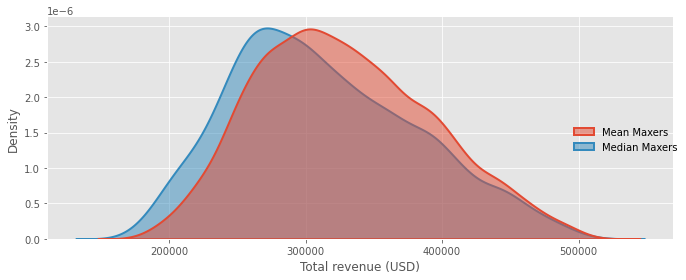

In [9]:
sns.displot(result_df ,kind='kde', height=4, aspect=2, 
            fill=True, gridsize=2000, alpha=0.5, linewidth=2)
plt.xlabel('Total revenue (USD)')
plt.tight_layout()
plt.savefig('results_comparision', dpi=500)

<AxesSubplot:xlabel='Company', ylabel='Win rate'>

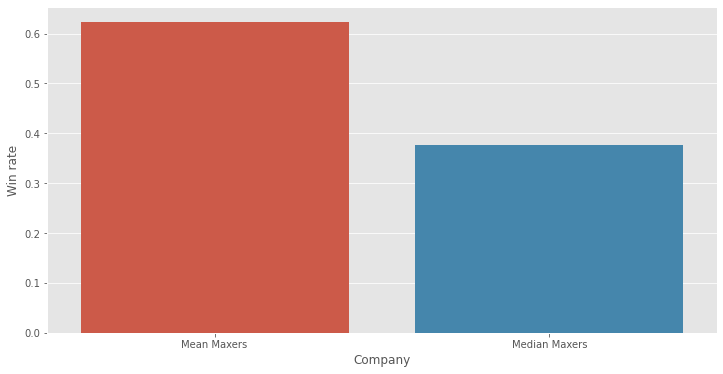

In [10]:
winner = result_df.apply(lambda row: result_df.columns[np.argmax(row)], axis=1)
win_rates = winner.value_counts(normalize=True).rename_axis('Company').reset_index(name='Win rate')
win_rates = win_rates.set_index('Company').loc[companies].reset_index()
sns.barplot(data=win_rates, x='Company', y='Win rate')

<AxesSubplot:xlabel='Company', ylabel='Average reward'>

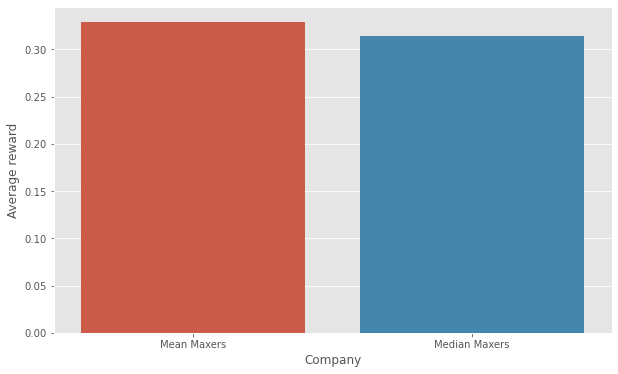

In [186]:
average_reward = result_df.mean().rename_axis('Company').reset_index(name='Average reward')
average_reward = average_reward.set_index('Company').loc[companies].reset_index()
sns.barplot(data=average_reward, x='Company', y='Average reward')

# How often do the companies agree?

In [14]:
mask = (selection_df['Mean Maxers'] != selection_df['Median Maxers'])
subset = result_df[mask]

In [17]:
np.sum(subset['Mean Maxers'] > subset['Median Maxers'] ) / len(subset)

0.8791357191087104